## Install Packages

In [3]:
!pip install pandas-datareader
!pip install scipy
!pip install --upgrade pandas-datareader

# Applying Markowitz in a stock portfolio

>Source: Edufinance (youtube: https://www.youtube.com/watch?v=BchQuTJvRAs)

## Import Modulles

In [1]:
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

## Preparing Stocks

In [2]:
#Cria lista de ações
lista_acoes = ['AMBP3.SA', 'XPBR31.SA', 'PRIO3.SA', 'OIBR3.SA', 'VAMO3.SA', 'MOVI3.SA']

#Pega preços das açoes da lista
precos = pdr.get_data_yahoo(lista_acoes, dt.date(2015, 1, 1), dt.date(2022, 12, 31))['Adj Close']

#Calcula os retornos logarítmicos (volatilidade / retorno contínuo)
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna()

#Calcula média dos retornos
media_retornos = retornos.mean()

#Cria matriz de covariância dos retornos
matriz_cov = retornos.cov()

## Portfolio Simulator

In [3]:
#Simulando 100.000 carteiras
numero_carteiras = 100000
vetor_retornos_esperados = np.zeros(numero_carteiras) #retorna um array com quantidade de linhas informadas com zero
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):

  pesos = np.random.random(len(lista_acoes))
  pesos = pesos/np.sum(pesos)
  tabela_pesos[k, :] = pesos

  vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
  vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov * 252, pesos)))

  vetor_sharpe[k] = vetor_retornos_esperados[k]/vetor_volatilidades_esperadas[k]

## Ploting Graphic

In [4]:
# transformando retornos esperados logarítmicos em retornos aritméticos
tabela_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1

In [5]:
#definindo eixo Y da fronteira eficiente

#cria uma sequência de números uniformemente espaçados (linspace) - 100 amostras
eixoYFronteiraEficiente = np.linspace(tabela_retornos_esperados_arit.min(),
                                     tabela_retornos_esperados_arit.max(), 100)

def pegandoRetorno(peso):
    peso = np.array(peso)
    retorno = np.sum(media_retornos * peso) * 252
    retorno = np.exp(retorno) - 1
    
    return retorno

def checandoSomaPesos(peso):
    return np.sum(peso) - 1

def pegandoVol(peso):
    peso = np.array(peso)
    vol = np.sqrt(np.dot(peso.T, np.dot(matriz_cov*252, peso)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes) #set initial weight
limites = tuple([(0,1) for ativo in lista_acoes]) #set initial axis

eixoXFronteiraEficiente = [] #set X array

for retorno_possivel in eixoYFronteiraEficiente:
    
    #pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun': checandoSomaPesos},
                 {'type': 'eq', 'fun': lambda w: pegandoRetorno(w) - retorno_possivel})
    
    #Otimiza os valores, menor vol para cada peso com limites entre 0 e 100    
    result = minimize(pegandoVol, peso_inicial, method='SLSQP', bounds=limites, constraints=restricoes)
    
    eixoXFronteiraEficiente.append(result['fun'])

posicao_sharpe_maximo = vetor_sharpe.argmax()

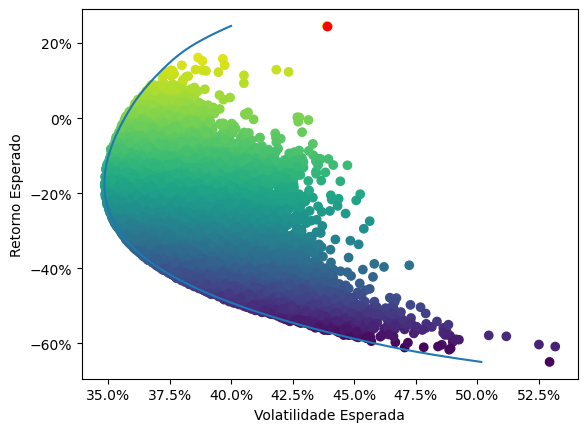

In [13]:
fig, ax = plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, tabela_retornos_esperados_arit, c = vetor_sharpe)
plt.xlabel('Volatilidade Esperada')
plt.ylabel('Retorno Esperado')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.scatter(vetor_volatilidades_esperadas[posicao_sharpe_maximo],
          tabela_retornos_esperados_arit[posicao_sharpe_maximo], c = 'red')
ax.plot(eixoXFronteiraEficiente, eixoYFronteiraEficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
#plt.ylim(-0.55,0.1)

plt.show()

## Portfolio Optimized

In [7]:
pesos_otimos = tabela_pesos[posicao_sharpe_maximo, :]
pesos_otimos = [str((peso * 100).round(2)) + "%" for peso in pesos_otimos]

for i, acao in enumerate(lista_acoes):
  print(f'Peso {acao}: {pesos_otimos[i]}')

print(f'Retorno Esperado: {tabela_retornos_esperados_arit[posicao_sharpe_maximo]*100:.4f}%')
print(f'Volatilidade Esperada: {vetor_volatilidades_esperadas[posicao_sharpe_maximo]*100:.4f}%')

Peso AMBP3.SA: 2.75%
Peso XPBR31.SA: 3.06%
Peso PRIO3.SA: 78.25%
Peso OIBR3.SA: 1.76%
Peso VAMO3.SA: 14.03%
Peso MOVI3.SA: 0.15%
Retorno Esperado: 24.5717%
Volatilidade Esperada: 43.8822%


In [8]:
pd.DataFrame(tabela_retornos_esperados_arit).to_excel('tabela_retornos_esperados_arit.xlsx', index=False)

In [9]:
pd.DataFrame(vetor_volatilidades_esperadas).to_excel('vetor_volatilidades_esperadas.xlsx', index=False)

In [11]:
pd.DataFrame(eixoXFronteiraEficiente).to_excel('eixoXFronteiraEficiente.xlsx', index=False)
pd.DataFrame(eixoYFronteiraEficiente).to_excel('eixoYFronteiraEficiente.xlsx', index=False)